# Section 5 
Using the dataset from https://archive.ics.uci.edu/ml/datasets/Car+Evaluation, create a machine learning model to predict the buying price given the following parameters:

- Maintenance = High
- Number of doors = 4
- Lug Boot Size = Big
- Safety = High
- Class Value = Good

# Overall strategy

1. Perform exploratory data analysis to see if there are any trends in the data or anomalies that need to be handled
2. Handle anomalies and clean data if any
3. Use various classification models to perform this multi-class classification task, then select the best performing model to make the prediction

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score

#NN:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [2]:
# load dataset
names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv('car.data', names=names, header=None)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


# EDA

In [3]:
# Check the data types of each column
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Summary statistics for numerical variables
print(df.describe())

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64
       buying maint doors persons lug_boot safety  class
count    1728  1728  1728    1728     1728   1728   1728
unique      4     4     4       3        3      3      4
top       med   med     2       2      med    med  unacc
freq      432   432   432     576      576    576   1210


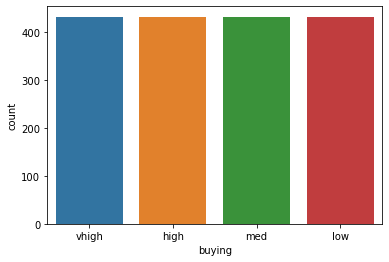

In [4]:
# Count plot for the target variable
sns.countplot(x='buying', data=df)
plt.show()

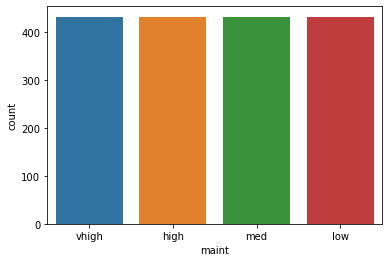

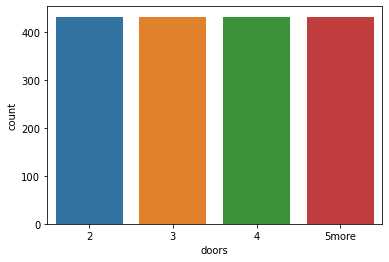

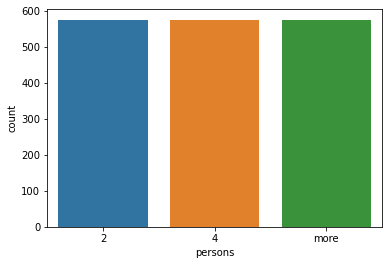

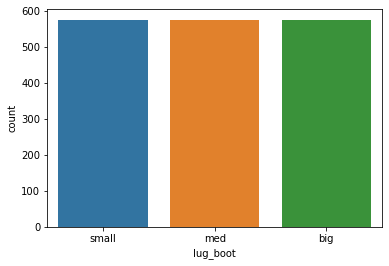

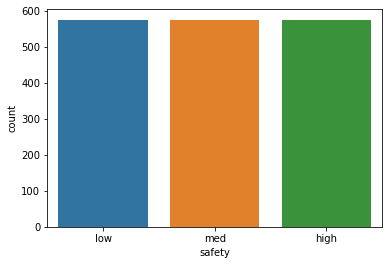

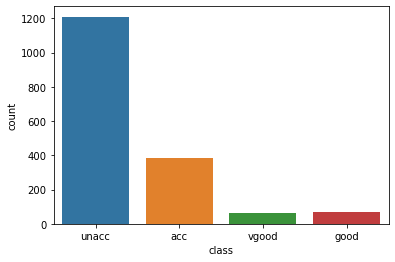

In [5]:
# Count plot for each categorical variable
sns.countplot(x='maint', data=df)
plt.show()

sns.countplot(x='doors', data=df)
plt.show()

sns.countplot(x='persons', data=df)
plt.show()

sns.countplot(x='lug_boot', data=df)
plt.show()

sns.countplot(x='safety', data=df)
plt.show()

sns.countplot(x='class', data=df)
plt.show()

In [10]:
display(pd.crosstab(df['maint'], df['buying']))
display(pd.crosstab(df['doors'], df['buying']))
display(pd.crosstab(df['persons'], df['buying']))
display(pd.crosstab(df['lug_boot'], df['buying']))
display(pd.crosstab(df['safety'], df['buying']))

# no relation at all

buying,high,low,med,vhigh
maint,,,,
high,108,108,108,108
low,108,108,108,108
med,108,108,108,108
vhigh,108,108,108,108


buying,high,low,med,vhigh
doors,,,,
2,108,108,108,108
3,108,108,108,108
4,108,108,108,108
5more,108,108,108,108


buying,high,low,med,vhigh
persons,,,,
2,144,144,144,144
4,144,144,144,144
more,144,144,144,144


buying,high,low,med,vhigh
lug_boot,,,,
big,144,144,144,144
med,144,144,144,144
small,144,144,144,144


buying,high,low,med,vhigh
safety,,,,
high,144,144,144,144
low,144,144,144,144
med,144,144,144,144


In [51]:
display(pd.crosstab(df['persons'], df['doors']))

doors,2,3,4,5more
persons,,,,
2,144,144,144,144
4,144,144,144,144
more,144,144,144,144


In [9]:
display(pd.crosstab(df['class'], df['buying']))
display(pd.crosstab(df['class'], df['buying'], normalize='columns'))

# in general, lower buying price means that the car is more acceptable

buying,high,low,med,vhigh
class,,,,
acc,108,89,115,72
good,0,46,23,0
unacc,324,258,268,360
vgood,0,39,26,0


buying,high,low,med,vhigh
class,,,,
acc,0.25,0.206019,0.266204,0.166667
good,0.00,0.106481,0.053241,0.000000
unacc,0.75,0.597222,0.620370,0.833333
vgood,0.00,0.090278,0.060185,0.000000


# Modeling

In [46]:
def gridsearch_classification(X_train, y_train):
    """Perform a grid search to find the best multi-class classification model and hyperparameters using f1 score."""
    
    # Define the classifiers to be tested
    classifiers = {'Decision Tree': DecisionTreeClassifier(),
                   'Random Forest': RandomForestClassifier(),
                   'Naive Bayes': GaussianNB(),
                   'SVC': SVC()}
    
    # Define the hyperparameters to be tested for each classifier
    param_grids = {'Decision Tree': {'max_depth': [3, 5, 7]},
                   'Random Forest': {'n_estimators': [50, 100, 150],
                                     'max_depth': [3, 5, 7]},
                   'Naive Bayes': {},
                   'SVC': {'C': [0.1, 1, 10],
                           'kernel': ['linear', 'rbf']}}
    
    # Perform a grid search for each classifier
    results = {}
    for name, classifier in classifiers.items():
        param_grid = param_grids[name]
        grid_search = GridSearchCV(estimator=classifier,
                                   param_grid=param_grid,
                                   cv=5,
                                   scoring='f1_macro')
        grid_search.fit(X_train, y_train)
        results[name] = {'best_params': grid_search.best_params_,
                         'best_score': grid_search.best_score_,
                         'best_estimator': grid_search.best_estimator_}
    
    # Print the results
    for name, result in results.items():
        print(f"{name}: Best parameters: {result['best_params']}")
        print(f"{name}: Best f1 score: {result['best_score']}")
    
    # Return the best model found
    best_model_name = max(results, key=lambda k: results[k]['best_score'])
    best_model = results[best_model_name]['best_estimator']
    print(f"Best model: {best_model_name}")
    return best_model

In [47]:
# Encode categorical variables using one-hot encoding
X_cols = ['maint','doors','persons','lug_boot','safety','class']
y = df['buying']
X = pd.get_dummies(df[X_cols],drop_first=True)

In [48]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Gridsearch for the best multiclass classification model 
best_model_cat = gridsearch_classification(X_train, y_train)

Decision Tree: Best parameters: {'max_depth': 5}
Decision Tree: Best f1 score: 0.28602930549430167
Random Forest: Best parameters: {'max_depth': 3, 'n_estimators': 150}
Random Forest: Best f1 score: 0.27377407847010615
Naive Bayes: Best parameters: {}
Naive Bayes: Best f1 score: 0.2464534372005625
SVC: Best parameters: {'C': 10, 'kernel': 'linear'}
SVC: Best f1 score: 0.3252433634263832
Best model: SVC


In [49]:
y_pred = best_model_cat.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'f1 score is {f1}')
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy is {round(accuracy,3)}') #given that this is a balanced dataset with 4 categories, baseline accuracy is 0.25. 

f1 score is 0.33260484322466016
accuracy is 0.332


# Modeling - neural network

In [32]:
# Encode the categorical features
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

# Split the dataset into features and target variable
X_nn = df_encoded.drop('buying', axis=1)
y_nn = df_encoded['buying']

# Split the dataset into training and testing sets
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_nn_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_nn)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(X_nn_train, keras.utils.to_categorical(y_nn_train), epochs=100, batch_size=16, validation_split=0.1)

# Evaluate the model on the test data
y_nn_pred = model.predict(X_nn_test)
y_nn_pred = np.argmax(y_nn_pred, axis=1)
f1 = f1_score(y_nn_test, y_nn_pred, average='macro')
print('F1-score: %.2f' % (f1*100))

Epoch 1/100
78/78 [==============================] - 1s 2ms/step - loss: 1.4279 - accuracy: 0.2357 - val_loss: 1.4052 - val_accuracy: 0.2446
Epoch 2/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3894 - accuracy: 0.2462 - val_loss: 1.3975 - val_accuracy: 0.2086
Epoch 3/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3809 - accuracy: 0.2703 - val_loss: 1.3916 - val_accuracy: 0.2230
Epoch 4/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3752 - accuracy: 0.2872 - val_loss: 1.3927 - val_accuracy: 0.2230
Epoch 5/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3717 - accuracy: 0.2776 - val_loss: 1.3890 - val_accuracy: 0.2302
Epoch 6/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3684 - accuracy: 0.2969 - val_loss: 1.3902 - val_accuracy: 0.2518
Epoch 7/100
78/78 [==============================] - 0s 1ms/step - loss: 1.3657 - accuracy: 0.2944 - val_loss: 1.3869 - val_accuracy: 0.2302
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2398 - accuracy: 0.3797 - val_loss: 1.3068 - val_accuracy: 0.2662
Epoch 60/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2406 - accuracy: 0.3765 - val_loss: 1.3264 - val_accuracy: 0.2806
Epoch 61/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2354 - accuracy: 0.3821 - val_loss: 1.3112 - val_accuracy: 0.3094
Epoch 62/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2372 - accuracy: 0.3733 - val_loss: 1.3168 - val_accuracy: 0.2806
Epoch 63/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2366 - accuracy: 0.3701 - val_loss: 1.3027 - val_accuracy: 0.2662
Epoch 64/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2371 - accuracy: 0.3813 - val_loss: 1.3053 - val_accuracy: 0.2662
Epoch 65/100
78/78 [==============================] - 0s 1ms/step - loss: 1.2374 - accuracy: 0.3749 - val_loss: 1.3084 - val_accuracy: 0.2950
Epoch 

In [56]:
print('accuracy is ', accuracy_score(y_nn_test, y_nn_pred))
print('f1 score is ', f1_score(y_nn_test, y_nn_pred, average='macro'))

accuracy is  0.23410404624277456
f1 score is  0.22681391551669405


In [52]:
## seems like the neural network is overfitting because the test set accuracy is much lower.

In [71]:
## seems like the neural network is overfitting because the test set accuracy is much lower.
## add dropout, regularization and early stoppage


# Encode the categorical features
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

# Split the dataset into features and target variable
X_nn = df_encoded.drop('buying', axis=1)
y_nn = df_encoded['buying']

# Split the dataset into training and testing sets
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_nn_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))#, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))#, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_nn)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model to the training data
history = model.fit(X_nn_train, keras.utils.to_categorical(y_nn_train), epochs=300, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test data
y_nn_pred = model.predict(X_nn_test)
y_nn_pred = np.argmax(y_nn_pred, axis=1)

print('accuracy is ', accuracy_score(y_nn_test, y_nn_pred))
print('f1 score is ', f1_score(y_nn_test, y_nn_pred, average='macro'))

Epoch 1/300
78/78 [==============================] - 1s 3ms/step - loss: 1.4847 - accuracy: 0.2663 - val_loss: 1.3930 - val_accuracy: 0.2806
Epoch 2/300
78/78 [==============================] - 0s 1ms/step - loss: 1.4291 - accuracy: 0.2365 - val_loss: 1.3853 - val_accuracy: 0.2446
Epoch 3/300
78/78 [==============================] - 0s 1ms/step - loss: 1.4165 - accuracy: 0.2212 - val_loss: 1.3822 - val_accuracy: 0.2950
Epoch 4/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3902 - accuracy: 0.2550 - val_loss: 1.3839 - val_accuracy: 0.2662
Epoch 5/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3901 - accuracy: 0.2832 - val_loss: 1.3846 - val_accuracy: 0.2374
Epoch 6/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3906 - accuracy: 0.2582 - val_loss: 1.3833 - val_accuracy: 0.2374
Epoch 7/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3866 - accuracy: 0.2679 - val_loss: 1.3840 - val_accuracy: 0.2662
Epoch 8/300
7

Epoch 59/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3367 - accuracy: 0.3162 - val_loss: 1.3230 - val_accuracy: 0.2806
Epoch 60/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3249 - accuracy: 0.3138 - val_loss: 1.3204 - val_accuracy: 0.2662
Epoch 61/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3274 - accuracy: 0.3025 - val_loss: 1.3227 - val_accuracy: 0.2662
Epoch 62/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3296 - accuracy: 0.3250 - val_loss: 1.3273 - val_accuracy: 0.2590
Epoch 63/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3281 - accuracy: 0.3073 - val_loss: 1.3237 - val_accuracy: 0.2662
Epoch 64/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3316 - accuracy: 0.3105 - val_loss: 1.3261 - val_accuracy: 0.2734
Epoch 65/300
78/78 [==============================] - 0s 1ms/step - loss: 1.3420 - accuracy: 0.3081 - val_loss: 1.3244 - val_accuracy: 0.2662
Epoch 

78/78 [==============================] - 0s 1ms/step - loss: 1.2859 - accuracy: 0.3138 - val_loss: 1.2507 - val_accuracy: 0.2734
Epoch 117/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2772 - accuracy: 0.3315 - val_loss: 1.2440 - val_accuracy: 0.3165
Epoch 118/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2918 - accuracy: 0.3073 - val_loss: 1.2490 - val_accuracy: 0.2950
Epoch 119/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2924 - accuracy: 0.3017 - val_loss: 1.2579 - val_accuracy: 0.2950
Epoch 120/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2830 - accuracy: 0.3379 - val_loss: 1.2499 - val_accuracy: 0.3094
Epoch 121/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2780 - accuracy: 0.3210 - val_loss: 1.2503 - val_accuracy: 0.3022
Epoch 122/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2810 - accuracy: 0.3347 - val_loss: 1.2483 - val_accuracy: 0.3165
Epoch 123/300

78/78 [==============================] - 0s 1ms/step - loss: 1.2543 - accuracy: 0.3556 - val_loss: 1.2148 - val_accuracy: 0.2950
Epoch 174/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2551 - accuracy: 0.3580 - val_loss: 1.2093 - val_accuracy: 0.2734
Epoch 175/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2631 - accuracy: 0.3435 - val_loss: 1.2183 - val_accuracy: 0.2950
Epoch 176/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2452 - accuracy: 0.3484 - val_loss: 1.2128 - val_accuracy: 0.3094
Epoch 177/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2547 - accuracy: 0.3500 - val_loss: 1.2054 - val_accuracy: 0.3022
Epoch 178/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2460 - accuracy: 0.3612 - val_loss: 1.2046 - val_accuracy: 0.3022
Epoch 179/300
78/78 [==============================] - 0s 1ms/step - loss: 1.2560 - accuracy: 0.3548 - val_loss: 1.2143 - val_accuracy: 0.2878
Epoch 180/300

In [ ]:
## Conclusion: SVC still performs better than neural network

# Prediction

## Input Parameters
- Maintenance = High
- Number of doors = 4
- Lug Boot Size = Big
- Safety = High
- Class Value = Good

Since SVC was found to be the best performing model, I will use SVC to make the prediction.

Unfortunately, 'persons' is not specified, which is currently a feature used in the model. 

There are 2 options to handle this:
1. re-train the model but without using persons as a feature
2. assume a value for persons (realistically, i would assume that persons is 'more' since there are 4 doors. however, the data is synthetic and there is no correlation between doors and persons

I will assume various values of persons to see if the prediction changes. if there is no change then we can assume that 'persons' does not impact the prediction.

In [72]:
# assuming persons is 'more'

input_data = {'maint_low':0,
              'maint_med':0,
              'maint_vhigh':0,
              'doors_3':0,
              'doors_4':1,
              'doors_5more':0,
              'persons_4':0,
              'persons_more':1,
              'lug_boot_med':0,
              'lug_boot_small':0,
              'safety_low':0,
              'safety_med':0,
              'class_good':1,
              'class_unacc':0,
              'class_vgood':0}
input_df = pd.DataFrame(input_data, index=[0])
best_model_cat.predict(input_df)

array(['low'], dtype=object)

In [73]:
# assuming persons is '4'

input_data = {'maint_low':0,
              'maint_med':0,
              'maint_vhigh':0,
              'doors_3':0,
              'doors_4':1,
              'doors_5more':0,
              'persons_4':1,
              'persons_more':0,
              'lug_boot_med':0,
              'lug_boot_small':0,
              'safety_low':0,
              'safety_med':0,
              'class_good':1,
              'class_unacc':0,
              'class_vgood':0}
input_df = pd.DataFrame(input_data, index=[0])
best_model_cat.predict(input_df)

array(['low'], dtype=object)

In [74]:
# assuming persons is '2'

input_data = {'maint_low':0,
              'maint_med':0,
              'maint_vhigh':0,
              'doors_3':0,
              'doors_4':1,
              'doors_5more':0,
              'persons_4':0,
              'persons_more':0,
              'lug_boot_med':0,
              'lug_boot_small':0,
              'safety_low':0,
              'safety_med':0,
              'class_good':1,
              'class_unacc':0,
              'class_vgood':0}
input_df = pd.DataFrame(input_data, index=[0])
best_model_cat.predict(input_df)

array(['low'], dtype=object)

# Conclusion

Regardless of the value of 'persons', the prediction for buying is still 'low'. 

Hence, based on this model, the prediction for 'buying' is 'low'.